In [1]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow

from res_utils import *
%matplotlib inline

#### ResNets allows a model to skip layers,  it has two main blocks Identity and Convolutional block

In [7]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(filters = F1, kernel_size = 1, strides=(1,1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training = training)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = F2, kernel_size = (f,f), strides=1, padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training = training)
    X = Activation('relu')(X)
    
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=1, padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training = training)
    
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    return X
    

In [11]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv2D(filters = F1, kernel_size = 1, strides=(s,s), padding = 'valid', kernel_initializer= initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = F2, kernel_size = (f,f), strides=(1,1), padding='same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = F3, kernel_size=1, strides=(1,1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides=(s,s), padding='valid', kernel_initializer=initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)
    X_shortcut = Activation('relu')(X_shortcut)
    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X
    
    
    

In [12]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)
    
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    
    X = convolutional_block(X, f = 3, filters= [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    X = convolutional_block(X, f=3, filters=[512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    X = AveragePooling2D(pool_size=(2, 2))(X)
    

    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    model = Model(inputs = X_input, outputs = X)

    return model

In [13]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 70, 70, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 32, 32, 64)   9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 32, 32, 64)   256         conv2d_23[0][0]                  
______________________________________________________________________________________________

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

In [16]:
model.fit(X_train, Y_train, epochs = 10, batch_size = 32)

Epoch 1/10
34/34 [==============================] - 60s 2s/step - loss: 3.2156 - accuracy: 0.3172
Epoch 2/10
34/34 [==============================] - 51s 1s/step - loss: 0.8432 - accuracy: 0.6723
Epoch 3/10
34/34 [==============================] - 57s 2s/step - loss: 0.3768 - accuracy: 0.8794
Epoch 4/10
34/34 [==============================] - 59s 2s/step - loss: 0.3996 - accuracy: 0.8594
Epoch 5/10
34/34 [==============================] - 53s 2s/step - loss: 0.3381 - accuracy: 0.8757
Epoch 6/10
34/34 [==============================] - 54s 2s/step - loss: 0.2839 - accuracy: 0.9132
Epoch 7/10
34/34 [==============================] - 60s 2s/step - loss: 0.2471 - accuracy: 0.9237
Epoch 8/10
34/34 [==============================] - 54s 2s/step - loss: 0.1102 - accuracy: 0.9677
Epoch 9/10
34/34 [==============================] - 51s 1s/step - loss: 0.0515 - accuracy: 0.9818
Epoch 10/10
34/34 [==============================] - 50s 1s/step - loss: 0.0550 - accuracy: 0.9779


In [17]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 3s 351ms/step - loss: 0.9940 - accuracy: 0.8083
Loss = 0.9940108060836792
Test Accuracy = 0.8083333373069763


sign number: 2


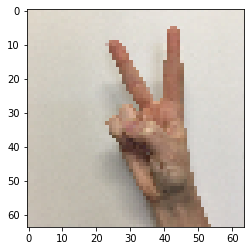

In [20]:
img_path = 'images/my_image.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
imshow(img)
prediction = model.predict(x)
print("sign number:", np.argmax(prediction))
